In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
chars = list('abcdefghijklmnopqrstuvwxyz')
stoi = { s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = { i+1:s for i, s in enumerate(chars)}
itos[0] = '.'
print(stoi)
print(itos)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
vocab_size = 27
block_size = 3
X, Y = [], []

for w in words:
#     print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
#         print(''.join(itos[i] for i in context), '->', ch)        
        context = context[1:] + [ix]
        
X = torch.tensor(X)    
Y = torch.tensor(Y)

In [6]:
def build_dataset(words):
    block_size = 3
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)    
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [7]:
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=g)
# C has shape 27 * 10
# C[X[ix]]
# X[ix] has shape 32 * 10
 
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5 / 3) * (1 / (n_embd**0.5))
# b1 = torch.randn(n_hidden, generator=g) * 0.01

W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
for p in parameters:
    p.requires_grad = True
print(sum(p.nelement() for p in parameters))

12097


(array([0.00205373, 0.        , 0.        , 0.00205373, 0.00410745,
        0.00410745, 0.01232235, 0.01232235, 0.00205373, 0.01437608,
        0.02259098, 0.03902079, 0.06161177, 0.0800953 , 0.10884746,
        0.13349217, 0.2238561 , 0.25671571, 0.32654238, 0.3840467 ,
        0.40458395, 0.56272083, 0.63665495, 0.63049377, 0.65513848,
        0.62844005, 0.70648162, 0.77836202, 0.69826672, 0.66951456,
        0.7126428 , 0.6243326 , 0.50521651, 0.50521651, 0.36350944,
        0.36761689, 0.30600512, 0.21153374, 0.20331884, 0.14376079,
        0.11090118, 0.06777295, 0.03080588, 0.03902079, 0.01642981,
        0.01848353, 0.01026863, 0.0082149 , 0.0082149 , 0.0082149 ]),
 array([-2.20705557, -2.12590224, -2.04474892, -1.96359559, -1.88244226,
        -1.80128894, -1.72013561, -1.63898229, -1.55782896, -1.47667563,
        -1.39552231, -1.31436898, -1.23321566, -1.15206233, -1.070909  ,
        -0.98975568, -0.90860235, -0.82744903, -0.7462957 , -0.66514237,
        -0.58398905, -0.50

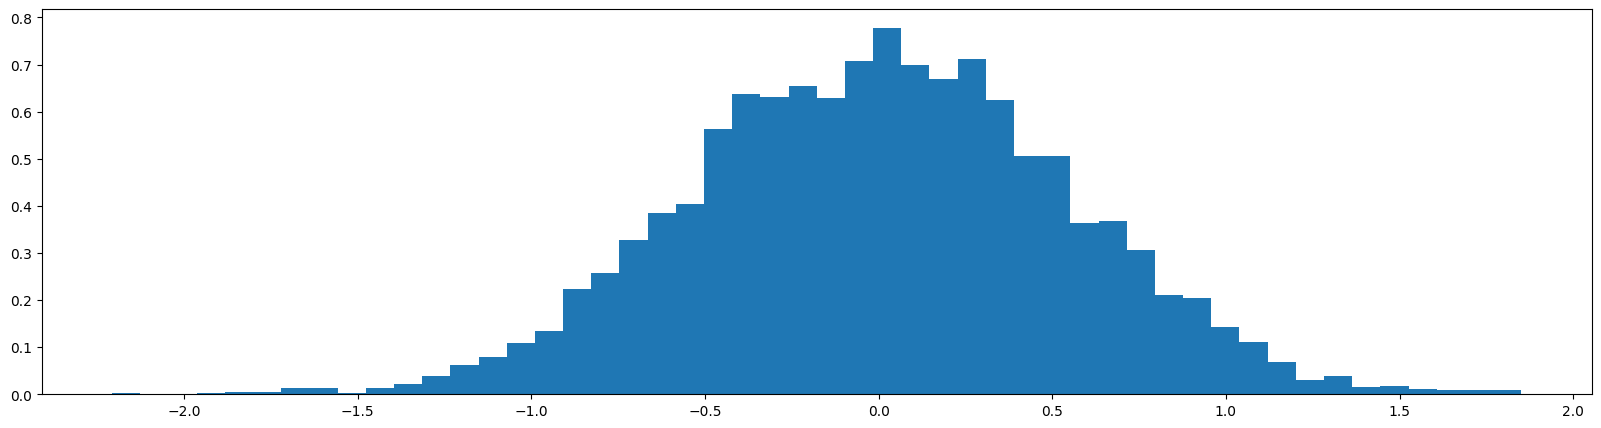

In [8]:
plt.figure(figsize=(20, 5))
plt.hist(W1.view(-1).tolist(), 50, density=True)

In [10]:
max_steps = 200000
batch_size = 32
lossi = []

for k in range(max_steps):
    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
    
    # Forward pass
    emb = C[Xtr[ix]]
#     print(C.shape)
    # C has shape 27 * 10
    # ix has shape 32 * 1
    # X has shape 32k * 3
    # X[ix] has shape 32 * 3
#     print(Xtr[ix].shape)
    # C[Xtr[ix]] has shape 32 * 3 * 10
#     print(C[Xtr[ix]].shape)
    embcat = emb.view(-1, block_size * n_embd)
    # embcat has shape 32 * 30
    # W1 has shape 30 * 200
    hpreact = embcat @ W1
    # b1 had shape 1 * 200
#     print(hpreact.shape)
    # hpreact has shape 32 * 200
    # bnmeani and bnstdi have shape 1 * 200, why? Because rows have be summed into one
    bnmeani = hpreact.mean(0, keepdim=True)
#     print(bnmeani.shape)
    bnstdi = hpreact.std(0, keepdim=True)
    # hpreact has shape 32 * 200
    # bnmeani has shape 1 * 200
    # Here from every row, bnmeani would be subtracted and then every row would be divided by bnstdi
    # This means inputs from every row (each row denoting an example) must follow a gaussian distribution.
    hpreact = (hpreact - bnmeani) / bnstdi
    hpreact = hpreact * bngain + bnbias
    h = torch.tanh(hpreact)
    # h has shape 32 * 200
    # W2 has shape 200 * 27
    # h * W2 has shape 32 * 27
    # b2 has shape 1 * 27
    logits = h @ W2 + b2
    # logits has size 32 * 27
    # Finally loss has shape 1 * 1
    loss = F.cross_entropy(logits, Ytr[ix])
    # So, we are training in batches. The loss is an aggregate over all examples in the batch. 
    
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnmean_running + 0.001 * bnstdi
    
    # Backprop
    for p in parameters :
        p.grad = None
    loss.backward()
    
    # Update parameters
    lr = 0.1 if k < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    if k % 10000 == 0 or k == 199999:
        print(f'{k:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.2879
  10000/ 200000: 2.6895
  20000/ 200000: 2.3757
  30000/ 200000: 2.2351
  40000/ 200000: 1.8494
  50000/ 200000: 2.5014
  60000/ 200000: 2.2398
  70000/ 200000: 1.8756
  80000/ 200000: 1.7561
  90000/ 200000: 2.2701
 100000/ 200000: 1.9203
 110000/ 200000: 2.3425
 120000/ 200000: 1.7792
 130000/ 200000: 2.0695
 140000/ 200000: 1.6431
 150000/ 200000: 2.0249
 160000/ 200000: 2.1560
 170000/ 200000: 2.2366
 180000/ 200000: 2.4849
 190000/ 200000: 2.1059
 199999/ 200000: 1.8248


In [ ]:
logits[0]
h
plt.hist(h.view(-1).tolist(), 50)

In [ ]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

In [ ]:
plt.plot(lossi)

In [ ]:
with torch.no_grad():
    emb = C[Xtr]
    embcat = emb.view(-1, n_embd * block_size)
    hpreact = embcat @ W1 + b1
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [ ]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'dev': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x]
    embcat = emb.view(-1, n_embd * block_size)
    hpreact = embcat @ W1 + b1
    hpreact = (hpreact - bnmean_running) / bnstd_running
    hpreact = hpreact * bngain + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('dev')
split_loss('test')

In [ ]:
# dev 2.1062495708465576
# test 2.1013145446777344

In [ ]:
g = torch.Generator().manual_seed(2147483647 + 10)
for _ in range(20):
    out = []
    context = [0] * block_size

    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim = 1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
            
    print(''.join(itos[i] for i in out))

In [145]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator = g) # / (fan_in**0.5)
        self.bias = torch.randn((fan_out), generator = g) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

In [146]:
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        self.gamma = torch.ones(dim) # gain
        self.beta = torch.zeros(dim) # bias
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim) 
        
    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim = True)
            xvar = x.var(0, keepdim = True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        
        if self.training:
            self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
            self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
            
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

In [147]:
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

In [154]:
n_embd = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd))
layers = [
    Linear(block_size * n_embd, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size), BatchNorm1d(vocab_size),
]

with torch.no_grad():
    layers[-1].gamma *= 0.1
    for layer in layers[:-1]:
        if (isinstance(layer, Linear)):
            layer.weight *= 1

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

47551


In [155]:
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for k in range(max_steps):
    # forward pass
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    emb = C[Xb]
    x = emb.view(-1, block_size * n_embd)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)
    
    # backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # parameter update
    lr = 1.0 if k < 100000 else 0.1
    for p in parameters:
        p.data += -lr * p.grad
    
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr * p.grad.std() / p.data.std()).log10().item() for p in parameters])
    if k % 100000 == 0:
        print(f'{k:7d}/{max_steps:7d}: {loss.item():.4f}')
    if k > 1000:
        break

      0/ 200000: 3.3073


layer 2 (      Tanh): mean -0.03, std 0.64, saturated: 3.38%
layer 5 (      Tanh): mean -0.01, std 0.63, saturated: 3.00%
layer 8 (      Tanh): mean -0.00, std 0.63, saturated: 2.69%
layer 11 (      Tanh): mean +0.01, std 0.64, saturated: 3.19%
layer 14 (      Tanh): mean -0.02, std 0.64, saturated: 2.75%


Text(0.5, 1.0, 'activation distribution')

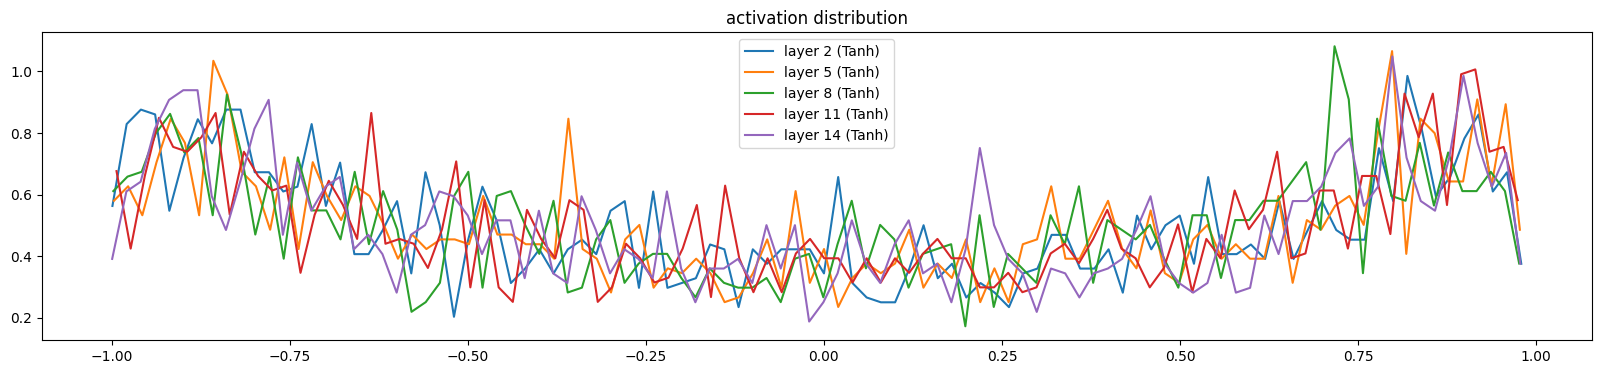

In [156]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if (isinstance(layer, Tanh)):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density = True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('activation distribution')

layer 2 (      Tanh): mean +0.000000, std 3.710413e-03
layer 5 (      Tanh): mean -0.000000, std 3.434282e-03
layer 8 (      Tanh): mean +0.000000, std 3.259557e-03
layer 11 (      Tanh): mean +0.000000, std 3.161157e-03
layer 14 (      Tanh): mean +0.000000, std 3.326817e-03


Text(0.5, 1.0, 'gradient distribution')

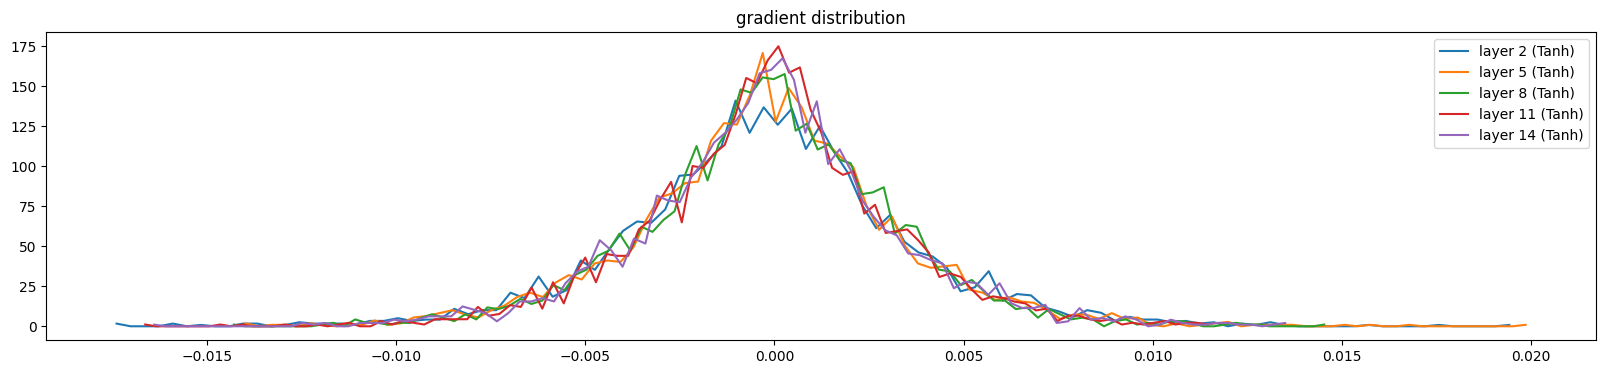

In [157]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if (isinstance(layer, Tanh)):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density = True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('gradient distribution')

weight   (27, 10) | mean -0.000000 | std 7.139670e-03 | grad:data ratio 6.897563e-03
weight  (30, 100) | mean -0.000013 | std 2.425386e-03 | grad:data ratio 2.390274e-03
weight (100, 100) | mean -0.000006 | std 1.187064e-03 | grad:data ratio 1.182255e-03
weight (100, 100) | mean -0.000008 | std 1.114979e-03 | grad:data ratio 1.115362e-03
weight (100, 100) | mean -0.000028 | std 1.139317e-03 | grad:data ratio 1.136872e-03
weight (100, 100) | mean -0.000006 | std 1.109244e-03 | grad:data ratio 1.098583e-03
weight  (100, 27) | mean +0.000001 | std 2.086548e-03 | grad:data ratio 2.083627e-03


Text(0.5, 1.0, 'weights gradient distribution')

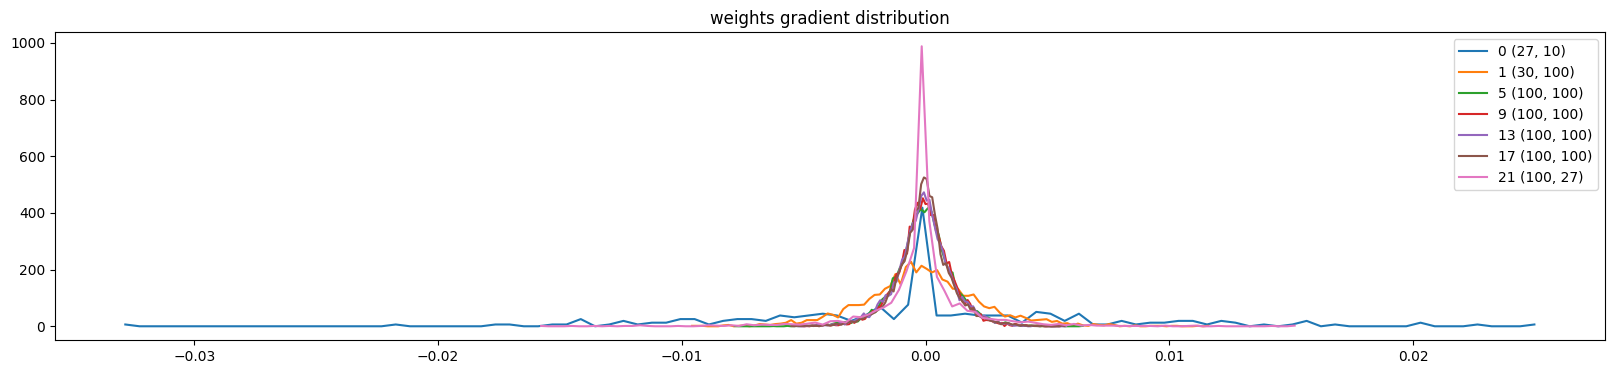

In [158]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        t = p.grad
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density = True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution')

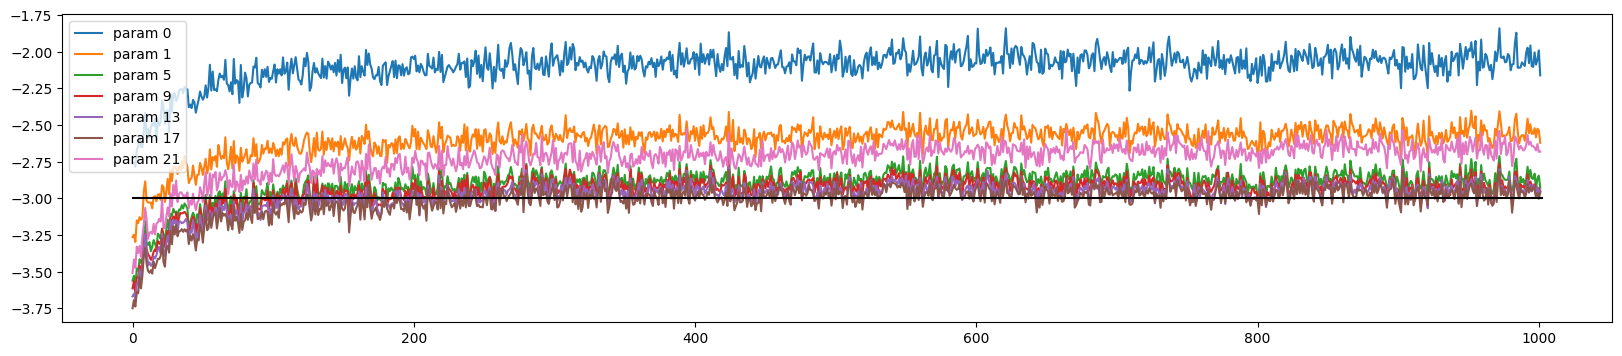

In [159]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k')
plt.legend(legends)

In [ ]:
# Why use std for getting ratios for things in array?